In [1]:
import torch
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config
from rdm.util import custom_to_pil
from experiments_util import MODEL_DPRDM_ADAPT005_PATH
from experiments_util import RETRIEVAL_DB_IMAGENET_METACLIP
from rdm.sample_generator import setup_model, format_args, SampleGenerator

def load_model(ckpt_path, config_path):
    config = OmegaConf.load(config_path)
    config.model.params.retrieval_cfg.params.load_patch_dataset = True
    config.model.params.retrieval_cfg.params.gpu = True
    # Load state dict
    pl_sd = torch.load(ckpt_path, map_location="cpu")
    # Initialize model
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(pl_sd["state_dict"], strict=False)
    model = model.eval()
    device = torch.device("cuda:0")
    model.to(device)
    return model 



/private/home/lebensold/dev/private-augmented-retrieval/src/clip/clip/clip.py:6: UserWarning: Module rdm was already imported from /private/home/lebensold/dev/private-augmented-retrieval/rdm/__init__.py, but /private/home/lebensold/dev/dp_rdm is being added to sys.path
  from pkg_resources import packaging


In [2]:
model = load_model(MODEL_DPRDM_ADAPT005_PATH, RETRIEVAL_DB_IMAGENET_METACLIP)

MinimalRETRODiffusion: Running in eps-prediction mode
Attention attention: num_heads: 30; dim_head: 32
Attention attention: num_heads: 30; dim_head: 32
Attention attention: num_heads: 30; dim_head: 32
Attention attention: num_heads: 30; dim_head: 32
Attention attention: num_heads: 18; dim_head: 32
Attention attention: num_heads: 18; dim_head: 32
Attention attention: num_heads: 18; dim_head: 32
Attention attention: num_heads: 12; dim_head: 32
Attention attention: num_heads: 12; dim_head: 32
Attention attention: num_heads: 12; dim_head: 32
DiffusionWrapper has 400.92 M params.
Keeping EMAs of 690.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Training MinimalRETRODiffusion as an unconditional model.
MinimalRETRODiffusion - agg: False, noise: 0.0, normalized embeddings: True 
RETRODiffusionWrapper: Wrapping diffusion model for RETRO training. For multimodal data, co

In [3]:
captions = [
    "A brown bear in the forest", 
    "A cute picture of a dog",
]
args = format_args(model, public_retrieval=False, 
                   captions=captions, 
                   k_nn=12, sigma=0.05, subsample_rate=1, aggregate=True, 
                   ddim_steps=50, guidance_scale=2., query_embedding_interpolation=1)
q = model.build_query(**args)

{'query': tensor([[-0.7198,  0.1152,  0.4367,  ...,  0.0605,  0.6562, -0.3100],
        [-0.3142,  0.1303,  0.3213,  ...,  0.2973,  0.2363, -0.0863]]), 'query_embedded': True, 'use_weights': False, 'ddim': True, 'visualize_nns': False, 'unconditional_retro_guidance_label': 0.0, 'k_nn': 12, 'unconditional_guidance_scale': 2.0, 'ddim_steps': 50, 'query_embedding_interpolation': 1, 'aggregate': True, 'public_retrieval': False, 'sigma': 0.05, 'return_nns': False, 'subsample_rate': 1}
training searcher...
Searcher DB Engine:  faiss
Train searcher faiss - shape (1281167, 512)
Adding to searcher (1281167, 512)
Finished
done training searcher
Query shape is (2, 512)
subsampling 1
Query time: 0.2870759963989258s
Fetching: 0.0007293224334716797s
Getting Patches: 1.049041748046875e-05s
r_enc shape torch.Size([2, 12, 512])


torch.Size([2, 12, 512])
Plotting: Switched to EMA weights
Using unconditonal diffusion guidance with scale 2.0
Data shape for DDIM sampling is (2, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

Plotting: Restored training weights


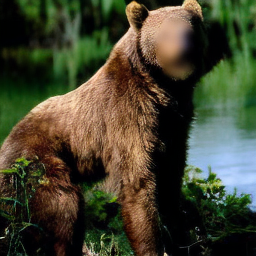

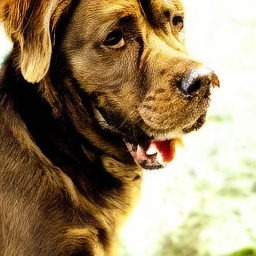

In [5]:
logs = model.sample_with_cached_query(**args, **q)
for idx,im in enumerate(logs['query_samples']):
    pilimg = custom_to_pil(im)
    display(pilimg)